# Capstone Project - The Battle of the Neighborhoods
### Applied Data Science Capstone by IBM/Coursera

## Table of contents
* [Introduction: Business Problem](#introduction)
* [Data](#data)
* [Methodology](#methodology)
* [Analysis](#analysis)
* [Results and Discussion](#results)
* [Conclusion](#conclusion)



## Introduction: Business Problem <a name="introduction"></a>

In this project we will try to find an optimal location for a restaurant. Specifically, this report will be targeted to stakeholders interested in opening an **convenience store** in **Bangkok**, Thailand.

Since there are lots of restaurants in Berlin we will try to detect **locations that are not already crowded with restaurants**. We are also particularly interested in **areas with no Italian restaurants in vicinity**. We would also prefer locations **as close to city center as possible**, assuming that first two conditions are met.

We will use our data science powers to generate a few most promissing neighborhoods based on this criteria. Advantages of each area will then be clearly expressed so that best possible final location can be chosen by stakeholders.  



<s>
Bangkok is one of the most visiting city in the world. When the visitors, especially international visitors, are planning to visit, they need to explore the places and try to fetch as much information as possible regarding the city
This can be the neighborhoods, locality, market, restaurant including neighborhoods analysis.
It would be valuable to have an application which could make it easy by considering a comparative analysis between the neighborhoods with provided factors.
This project helps the end users to achieve the results by recommending the top 5 venues in each neighborhood of Bangkok.</s>

## Data and APIs <a name="data"></a>

Following data sources will be needed to extract/generate the required information:
- coordinate of Bangkok district, we will use data provide on wikipedia
- number of venue and their type and location in every neighborhood will be obtained using Foursquare API

<s> Based on definition of our problem, factors that will influence our decission are:
* number of existing restaurants in the neighborhood (any type of restaurant)
* number of and distance to Italian restaurants in the neighborhood, if any
* distance of neighborhood from city center

We decided to use regularly spaced grid of locations, centered around city center, to define our neighborhoods.

Following data sources will be needed to extract/generate the required information:
* centers of candidate areas will be generated algorithmically and approximate addresses of centers of those areas will be obtained using **Google Maps API reverse geocoding**
* number of restaurants and their type and location in every neighborhood will be obtained using **Foursquare API**
* coordinate of Berlin center will be obtained using **Google Maps API geocoding** of well known Berlin location (Alexanderplatz)

## Coordinate data of each district of Bangkok
We need a coordinate of each district of Bangkok. We will scaping from https://en.wikipedia.org/wiki/List_of_districts_of_Bangkok using package BeautifulSoup

In [42]:
import pandas as pd
import numpy as np
import requests 
from bs4 import BeautifulSoup 

req = requests.get("https://en.wikipedia.org/wiki/List_of_districts_of_Bangkok") 
soup = BeautifulSoup(req.content,'lxml') 
table = soup.find_all('table')[0]  
bkk = pd.read_html(str(table)) 

bkk =pd.DataFrame(bkk[0])
print("We found ",bkk.shape[0]," row of district. The following table show the first 10 rows")
bkk.head(10)

We found  50  row of district. The following table show the first 10 rows


,District(Khet),MapNr,Post-code,Thai,Popu-lation,No. ofSubdis-trictsKhwaeng,Latitude,Longitude
0,Bang Bon,50,10150,บางบอน,105161,4,13.659200,100.399100
1,Bang Kapi,6,10240,บางกะปิ,148465,2,13.765833,100.647778
2,Bang Khae,40,10160,บางแค,191781,4,13.696111,100.409444
3,Bang Khen,5,10220,บางเขน,189539,2,13.873889,100.596389
4,Bang Kho Laem,31,10120,บางคอแหลม,94956,3,13.693333,100.502500
5,Bang Khun Thian,21,10150,บางขุนเทียน,165491,2,13.660833,100.435833
6,Bang Na,47,10260,บางนา,95912,2,13.680081,100.591800
7,Bang Phlat,25,10700,บางพลัด,99273,4,13.793889,100.505000
8,Bang Rak,4,10500,บางรัก,45875,5,13.730833,100.524167
9,Bang Sue,29,10800,บางซื่อ,132234,2,13.809722,100.537222


Now, we get the table of coordinate from wikipedia. For the propose of using these data in this project, we will drop some columns and rename the left. 

In [47]:
bkk = bkk.drop(['MapNr','Post-code','Thai'],1)
bkk.rename(index=str, columns={"District(Khet)":"District","Popu-lation":"Population","No. ofSubdis-trictsKhwaeng":"num_subdistrict"},inplace=True)

In [48]:
bkk.head()

,District,Population,num_subdistrict,Latitude,Longitude
0,Bang Bon,105161,4,13.659200,100.399100
1,Bang Kapi,148465,2,13.765833,100.647778
2,Bang Khae,191781,4,13.696111,100.409444
3,Bang Khen,189539,2,13.873889,100.596389
4,Bang Kho Laem,94956,3,13.693333,100.502500


In [49]:
bkk.dtypes

District            object
Population           int64
num_subdistrict      int64
Latitude           float64
Longitude          float64
dtype: object

In [50]:
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt

[[ 1.         -0.04673644]
 [-0.04673644  1.        ]]


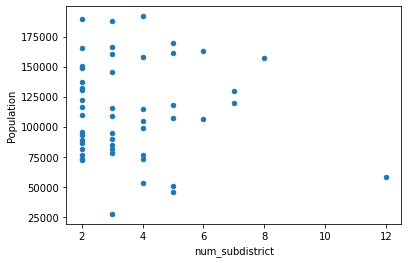

In [58]:
#scatter plot of population and no. of subdistrict
bkk.plot(kind="scatter",x="num_subdistrict",y="Population")
#print (np.corrcoef(bkk['num_subdistrict'],bkk['Population']))

In [29]:
import matplotlib.cm as cm
import matplotlib.colors as colors
import folium

# create map of Bangkok using latitude and longitude values 13.736717, 100.523186
# for the purpose of visualize, we manually adjust the center of the map

map_bkk = folium.Map(location=[13.76, 100.6], zoom_start=11)

# add markers to map
for lat, lng, district in zip(bkk['Latitude'], bkk['Longitude'], bkk['District']):
    label = '{}'.format(district)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7).add_to(map_bkk)  
    
map_bkk

## Foursquare

Foursquare credentials are defined in hidden cell bellow.

In [59]:
#Foursquare credential and versions

#Hide credential detail
CLIENT_ID = '0XP33P2YTO5FSJN4F4XUXVIXREEZTAVU1GLDYHV5UXB5NYEA' # your Foursquare ID
CLIENT_SECRET = 'DNBVVHTS1O0QWGURKQH4BCLNLHG02D0DQH0EGM0KS5QC1JLO' # your Foursquare Secret
VERSION = '20210117' # Foursquare API version

In [60]:
#Get the top 100 venues nearby each district within a radius of 2000 meters.
radius = 2000
LIMIT = 100

venues = []

for lat, long, district in zip(bkk['Latitude'], bkk['Longitude'], bkk['District']):
    url = "https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}".format(
        CLIENT_ID,
        CLIENT_SECRET,
        VERSION,
        lat,
        long,
        radius, 
        LIMIT)
    
    results = requests.get(url).json()["response"]['groups'][0]['items']
    
    for venue in results:
        venues.append((
            district, 
            lat, 
            long, 
            venue['venue']['name'], 
            venue['venue']['location']['lat'], 
            venue['venue']['location']['lng'],  
            venue['venue']['categories'][0]['name']))

In [64]:
# convert the venues list into a DataFrame
venues_df = pd.DataFrame(venues)

# name the column
venues_df.columns = ['District', 'DistrictLatitude', 'DistrictLongitude', 'VenueName', 'VenueLatitude', 'VenueLongitude', 'VenueCategory']

print(venues_df.shape)
venues_df.head()

(4374, 7)


,District,DistrictLatitude,DistrictLongitude,VenueName,VenueLatitude,VenueLongitude,VenueCategory
0,Bang Bon,13.6592,100.3991,ขาหมูบางหว้า,13.657136,100.395230,Thai Restaurant
1,Bang Bon,13.6592,100.3991,ร้านต้นไม้ ริมถนนกาญจนาภิเษก,13.654098,100.405054,Garden Center
2,Bang Bon,13.6592,100.3991,TPD Bowling,13.663977,100.408965,Bowling Alley
3,Bang Bon,13.6592,100.3991,KFC,13.670449,100.405502,Fast Food Restaurant
4,Bang Bon,13.6592,100.3991,เจ๊ไน้ ก๋วยเตี๋ยวเป็ดตุ๋น,13.654137,100.405323,Noodle House


In [65]:
venues_df.groupby(["District"]).count()

,DistrictLatitude,DistrictLongitude,VenueName,VenueLatitude,VenueLongitude,VenueCategory
District,,,,,,
Bang Bon,53,53,53,53,53,53
Bang Kapi,100,100,100,100,100,100
Bang Khae,67,67,67,67,67,67
Bang Khen,95,95,95,95,95,95
Bang Kho Laem,100,100,100,100,100,100
Bang Khun Thian,92,92,92,92,92,92
Bang Na,81,81,81,81,81,81
Bang Phlat,100,100,100,100,100,100
Bang Rak,100,100,100,100,100,100


In [71]:
#Content analysis: how many unique categories can found in the list of venues?
print('There are {} unique categories.'.format(len(venues_df['VenueCategory'].unique())))

There are 264 unique categories.


In [131]:
venue_unique_count = venues_df['VenueCategory'].value_counts().to_frame(name='Count')
venue_unique_count.head(20)

,Count
Noodle House,370
Thai Restaurant,352
Coffee Shop,326
Convenience Store,263
Café,172
Hotel,127
Asian Restaurant,119
Japanese Restaurant,117
Som Tum Restaurant,101
Bar,97


## Analyze Neighborhood

In [80]:
# one hot encoding
bkk_onehot = pd.get_dummies(venues_df[['VenueCategory']], prefix="", prefix_sep="")

# add District column back to dataframe
bkk_onehot['District'] = venues_df['District'] 

# move District column to the first column
fixed_columns = list(bkk_onehot.columns[-1:]) + list(bkk_onehot.columns[:-1])
bkk_onehot = bkk_onehot[fixed_columns]

print(bkk_onehot.shape)
bkk_onehot.head()

(4374, 265)


,District,Accessories Store,Airport,Airport Food Court,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Aquarium,Arcade,...,Water Park,Whisky Bar,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio,Yoshoku Restaurant,Zoo,Zoo Exhibit
0,Bang Bon,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Bang Bon,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Bang Bon,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Bang Bon,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Bang Bon,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [74]:
list(bkk_onehot.columns[-1:])

['Zoo Exhibit']

In [81]:
#Group the rows by Neighborhood, then compute mean occurrence by category
bkk_grouped = bkk_onehot.groupby(["District"]).mean().reset_index()

print(bkk_grouped.shape)
bkk_grouped

(50, 265)


,District,Accessories Store,Airport,Airport Food Court,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Aquarium,Arcade,...,Water Park,Whisky Bar,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio,Yoshoku Restaurant,Zoo,Zoo Exhibit
0,Bang Bon,0.00,0.00,0.00,0.00,0.000000,0.00,0.000000,0.00,0.000000,...,0.018868,0.00,0.00,0.00000,0.000000,0.00,0.00,0.00,0.000000,0.000000
1,Bang Kapi,0.00,0.00,0.00,0.00,0.000000,0.00,0.000000,0.00,0.000000,...,0.010000,0.00,0.00,0.00000,0.010000,0.00,0.00,0.00,0.000000,0.000000
2,Bang Khae,0.00,0.00,0.00,0.00,0.000000,0.00,0.000000,0.00,0.000000,...,0.014925,0.00,0.00,0.00000,0.000000,0.00,0.00,0.00,0.000000,0.000000
3,Bang Khen,0.00,0.00,0.00,0.00,0.000000,0.00,0.000000,0.00,0.000000,...,0.000000,0.00,0.00,0.00000,0.000000,0.00,0.00,0.00,0.000000,0.000000
4,Bang Kho Laem,0.00,0.00,0.00,0.00,0.000000,0.00,0.000000,0.00,0.000000,...,0.000000,0.01,0.01,0.00000,0.000000,0.00,0.00,0.00,0.000000,0.000000
5,Bang Khun Thian,0.00,0.00,0.00,0.00,0.000000,0.00,0.000000,0.00,0.000000,...,0.000000,0.00,0.00,0.01087,0.000000,0.00,0.00,0.00,0.000000,0.000000
6,Bang Na,0.00,0.00,0.00,0.00,0.000000,0.00,0.000000,0.00,0.000000,...,0.000000,0.00,0.00,0.00000,0.000000,0.00,0.00,0.00,0.000000,0.000000
7,Bang Phlat,0.00,0.00,0.00,0.00,0.000000,0.00,0.000000,0.00,0.000000,...,0.000000,0.00,0.00,0.00000,0.000000,0.00,0.00,0.00,0.000000,0.000000
8,Bang Rak,0.00,0.00,0.00,0.00,0.000000,0.00,0.000000,0.00,0.000000,...,0.000000,0.00,0.01,0.00000,0.000000,0.00,0.00,0.00,0.000000,0.000000
9,Bang Sue,0.00,0.00,0.00,0.00,0.000000,0.00,0.000000,0.00,0.000000,...,0.000000,0.01,0.00,0.00000,0.000000,0.01,0.00,0.00,0.000000,0.010000


## Top 10 venue of each neighborhood

In [83]:
#Now create a dataframe that displays the top 10 venues by PostalCode.
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
areaColumns = ['District']
freqColumns = []
for ind in np.arange(num_top_venues):
    try:
        freqColumns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        freqColumns.append('{}th Most Common Venue'.format(ind+1))
columns = areaColumns+freqColumns

# create a new dataframe
district_venues_sorted = pd.DataFrame(columns=columns)
district_venues_sorted['District'] = bkk_grouped['District']

for ind in np.arange(bkk_grouped.shape[0]):
    row_categories = bkk_grouped.iloc[ind, :].iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    district_venues_sorted.iloc[ind, 1:] = row_categories_sorted.index.values[0:num_top_venues]

# district_venues_sorted.sort_values(freqColumns, inplace=True)
print(district_venues_sorted.shape)
district_venues_sorted

(50, 11)


,District,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Bang Bon,Convenience Store,Asian Restaurant,Coffee Shop,Fast Food Restaurant,Noodle House,Japanese Restaurant,Thai Restaurant,Chinese Restaurant,Som Tum Restaurant,Food Truck
1,Bang Kapi,Noodle House,Coffee Shop,Thai Restaurant,Japanese Restaurant,Som Tum Restaurant,Dessert Shop,Clothing Store,Steakhouse,Shabu-Shabu Restaurant,Hotpot Restaurant
2,Bang Khae,Coffee Shop,Noodle House,Thai Restaurant,Shopping Mall,Seafood Restaurant,Japanese Restaurant,Dessert Shop,Fast Food Restaurant,Night Market,BBQ Joint
3,Bang Khen,Coffee Shop,Convenience Store,Som Tum Restaurant,Noodle House,Fast Food Restaurant,Hotpot Restaurant,Asian Restaurant,Hotel,Vietnamese Restaurant,Bookstore
4,Bang Kho Laem,Noodle House,Thai Restaurant,Hotel,Coffee Shop,Pub,Chinese Restaurant,Hotpot Restaurant,Seafood Restaurant,Convenience Store,Asian Restaurant
5,Bang Khun Thian,Coffee Shop,Noodle House,Hotpot Restaurant,Thai Restaurant,Bakery,Japanese Restaurant,Flea Market,Ice Cream Shop,Seafood Restaurant,Convenience Store
6,Bang Na,Convenience Store,Noodle House,Coffee Shop,Thai Restaurant,Café,Fast Food Restaurant,Hotel,Restaurant,Gas Station,Train Station
7,Bang Phlat,Thai Restaurant,Convenience Store,Noodle House,Coffee Shop,Café,Hotel,Asian Restaurant,Ice Cream Shop,BBQ Joint,Fast Food Restaurant
8,Bang Rak,Hotel,Chinese Restaurant,Café,Coffee Shop,Spa,Thai Restaurant,Seafood Restaurant,Bar,Noodle House,Dessert Shop
9,Bang Sue,Thai Restaurant,Noodle House,Coffee Shop,Som Tum Restaurant,Train Station,Café,Ice Cream Shop,Pet Store,Park,BBQ Joint


## Clustering using K-Means clustering

In [87]:
#Elbow criterion method
# Import key libraries
from sklearn.cluster import KMeans
import seaborn as sns
from matplotlib import pyplot as plt

In [89]:
# Fit KMeans and calculate SSE for each *k*
sse = {}
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=1)
    kmeans.fit(bkk_grouped_clustering)
    sse[k] = kmeans.inertia_ # sum of squared distances to closest cluster center

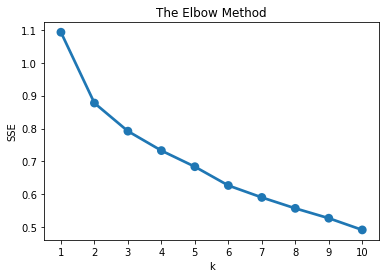

In [90]:
# Plot SSE for each *k*
plt.title('The Elbow Method')
plt.xlabel('k'); plt.ylabel('SSE')
sns.pointplot(x=list(sse.keys()), y=list(sse.values()))
plt.show()

In [84]:
#import k-means
from sklearn.cluster import KMeans

# set number of clusters
kclusters = 5

bkk_grouped_clustering = bkk_grouped.drop(["District"], 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(bkk_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]

array([1, 0, 4, 1, 0, 4, 3, 3, 2, 0])

In [85]:
# create a new dataframe that includes the cluster as well as the top 10 venues for each neighborhood.
bkk_merged = bkk.copy()

# add clustering labels
bkk_merged["Cluster Labels"] = kmeans.labels_

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
bkk_merged = bkk_merged.join(district_venues_sorted.set_index("District"), on="District")

print(bkk_merged.shape)
bkk_merged.head()

(50, 16)


,District,Population,num_subdistrict,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Bang Bon,105161,4,13.659200,100.399100,1,Convenience Store,Asian Restaurant,Coffee Shop,Fast Food Restaurant,Noodle House,Japanese Restaurant,Thai Restaurant,Chinese Restaurant,Som Tum Restaurant,Food Truck
1,Bang Kapi,148465,2,13.765833,100.647778,0,Noodle House,Coffee Shop,Thai Restaurant,Japanese Restaurant,Som Tum Restaurant,Dessert Shop,Clothing Store,Steakhouse,Shabu-Shabu Restaurant,Hotpot Restaurant
2,Bang Khae,191781,4,13.696111,100.409444,4,Coffee Shop,Noodle House,Thai Restaurant,Shopping Mall,Seafood Restaurant,Japanese Restaurant,Dessert Shop,Fast Food Restaurant,Night Market,BBQ Joint
3,Bang Khen,189539,2,13.873889,100.596389,1,Coffee Shop,Convenience Store,Som Tum Restaurant,Noodle House,Fast Food Restaurant,Hotpot Restaurant,Asian Restaurant,Hotel,Vietnamese Restaurant,Bookstore
4,Bang Kho Laem,94956,3,13.693333,100.502500,0,Noodle House,Thai Restaurant,Hotel,Coffee Shop,Pub,Chinese Restaurant,Hotpot Restaurant,Seafood Restaurant,Convenience Store,Asian Restaurant


## Add cluster on map

In [86]:
# create map
map_clusters = folium.Map(location=[13.76, 100.6], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i+x+(i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, district, cluster in zip(bkk_merged['Latitude'], bkk_merged['Longitude'], bkk_merged['District'], bkk_merged['Cluster Labels']):
    label = folium.Popup('{} : Cluster {}'.format(district, cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

In [119]:
bkk_merged[bkk_merged['Cluster Labels']==0]

,District,Population,num_subdistrict,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
1,Bang Kapi,148465,2,13.765833,100.647778,0,Noodle House,Coffee Shop,Thai Restaurant,Japanese Restaurant,Som Tum Restaurant,Dessert Shop,Clothing Store,Steakhouse,Shabu-Shabu Restaurant,Hotpot Restaurant
4,Bang Kho Laem,94956,3,13.693333,100.502500,0,Noodle House,Thai Restaurant,Hotel,Coffee Shop,Pub,Chinese Restaurant,Hotpot Restaurant,Seafood Restaurant,Convenience Store,Asian Restaurant
9,Bang Sue,132234,2,13.809722,100.537222,0,Thai Restaurant,Noodle House,Coffee Shop,Som Tum Restaurant,Train Station,Café,Ice Cream Shop,Pet Store,Park,BBQ Joint
17,Dusit,107655,5,13.776944,100.520556,0,Noodle House,Thai Restaurant,Coffee Shop,Café,Museum,Palace,Hotel,Dessert Shop,Asian Restaurant,Chinese Restaurant
18,Huai Khwang,78175,3,13.776667,100.579444,0,Noodle House,Thai Restaurant,Hotel,Convenience Store,Coffee Shop,Korean Restaurant,Asian Restaurant,Theater,Japanese Restaurant,Dessert Shop
34,Pom Prap Sattru Phai,51006,5,13.758056,100.513056,0,Noodle House,Thai Restaurant,Asian Restaurant,Hotel,Hostel,Bar,Palace,Museum,Coffee Shop,Chinese Restaurant
42,Suan Luang,115658,3,13.730278,100.651389,0,Noodle House,Thai Restaurant,Convenience Store,Coffee Shop,Japanese Restaurant,Som Tum Restaurant,Chinese Restaurant,Fast Food Restaurant,Supermarket,BBQ Joint
43,Taling Chan,106604,6,13.776944,100.456667,0,Noodle House,Café,Coffee Shop,Thai Restaurant,Convenience Store,Asian Restaurant,Som Tum Restaurant,Japanese Restaurant,Steakhouse,Restaurant
45,Thon Buri,119708,7,13.725000,100.485833,0,Noodle House,Convenience Store,Seafood Restaurant,Thai Restaurant,Asian Restaurant,Steakhouse,Hotpot Restaurant,Dessert Shop,Coffee Shop,Japanese Restaurant
47,Wang Thonglang,114768,4,13.786400,100.608700,0,Noodle House,Coffee Shop,Thai Restaurant,Café,Asian Restaurant,Chinese Restaurant,Badminton Court,Hotpot Restaurant,Restaurant,Fast Food Restaurant


In [120]:
bkk_merged[bkk_merged['Cluster Labels']==1]

,District,Population,num_subdistrict,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Bang Bon,105161,4,13.659200,100.399100,1,Convenience Store,Asian Restaurant,Coffee Shop,Fast Food Restaurant,Noodle House,Japanese Restaurant,Thai Restaurant,Chinese Restaurant,Som Tum Restaurant,Food Truck
3,Bang Khen,189539,2,13.873889,100.596389,1,Coffee Shop,Convenience Store,Som Tum Restaurant,Noodle House,Fast Food Restaurant,Hotpot Restaurant,Asian Restaurant,Hotel,Vietnamese Restaurant,Bookstore
10,Bangkok Noi,117793,5,13.770867,100.467933,1,Convenience Store,Noodle House,Coffee Shop,Café,Som Tum Restaurant,Japanese Restaurant,Steakhouse,Supermarket,Ice Cream Shop,Thai Restaurant
11,Bangkok Yai,72321,2,13.722778,100.476389,1,Convenience Store,Noodle House,Thai Restaurant,Asian Restaurant,Train Station,Steakhouse,Hotpot Restaurant,Seafood Restaurant,Dessert Shop,Japanese Restaurant
12,Bueng Kum,145830,3,13.785278,100.669167,1,Thai Restaurant,Noodle House,Coffee Shop,Convenience Store,Café,Supermarket,Ice Cream Shop,Japanese Restaurant,Bakery,Som Tum Restaurant
16,Don Mueang,166261,3,13.913611,100.589722,1,Coffee Shop,Convenience Store,Noodle House,Airport Service,Thai Restaurant,Fast Food Restaurant,Café,Airport Lounge,Grocery Store,Hotel
19,Khan Na Yao,88678,2,13.827100,100.674300,1,Coffee Shop,Noodle House,Convenience Store,Thai Restaurant,Ice Cream Shop,Café,Japanese Restaurant,Asian Restaurant,Steakhouse,BBQ Joint
20,Khlong Sam Wa,169489,5,13.859722,100.704167,1,Thai Restaurant,Noodle House,Convenience Store,Coffee Shop,Zoo,Food & Drink Shop,Restaurant,Exhibit,Golf Course,Soccer Field
23,Lak Si,109770,2,13.887500,100.578889,1,Coffee Shop,Convenience Store,Thai Restaurant,Hotel,Fast Food Restaurant,Gym / Fitness Center,Food Court,Badminton Court,Japanese Restaurant,Noodle House
24,Lat Krabang,163175,6,13.722317,100.759669,1,Thai Restaurant,Convenience Store,Hotel,Som Tum Restaurant,Bar,Noodle House,Train Station,Coffee Shop,Café,Dessert Shop


In [121]:
bkk_merged[bkk_merged['Cluster Labels']==2]

,District,Population,num_subdistrict,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
8,Bang Rak,45875,5,13.730833,100.524167,2,Hotel,Chinese Restaurant,Café,Coffee Shop,Spa,Thai Restaurant,Seafood Restaurant,Bar,Noodle House,Dessert Shop
21,Khlong San,76446,4,13.730278,100.509722,2,Chinese Restaurant,Noodle House,Hotel,Café,Bar,Dessert Shop,Spa,Restaurant,Coffee Shop,Seafood Restaurant
33,Phra Nakhon,57876,12,13.764444,100.499167,2,Thai Restaurant,Hotel,Bar,Hostel,History Museum,Noodle House,Museum,Café,Asian Restaurant,Coffee Shop
39,Samphanthawong,27452,3,13.731389,100.514167,2,Noodle House,Chinese Restaurant,Hotel,Bar,Dessert Shop,Café,Hotel Bar,Coffee Shop,Spa,Restaurant
41,Sathon,84916,3,13.708056,100.526389,2,Noodle House,Asian Restaurant,Hotel,Thai Restaurant,Coffee Shop,Spa,Som Tum Restaurant,Café,Bar,Dessert Shop


In [122]:
bkk_merged[bkk_merged['Cluster Labels']==3]

,District,Population,num_subdistrict,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
6,Bang Na,95912,2,13.680081,100.591800,3,Convenience Store,Noodle House,Coffee Shop,Thai Restaurant,Café,Fast Food Restaurant,Hotel,Restaurant,Gas Station,Train Station
7,Bang Phlat,99273,4,13.793889,100.505000,3,Thai Restaurant,Convenience Store,Noodle House,Coffee Shop,Café,Hotel,Asian Restaurant,Ice Cream Shop,BBQ Joint,Fast Food Restaurant
14,Chom Thong,158005,4,13.677222,100.484722,3,Convenience Store,Thai Restaurant,Coffee Shop,Hotpot Restaurant,Noodle House,Flea Market,BBQ Joint,Asian Restaurant,Night Market,Pub
26,Min Buri,137251,2,13.813889,100.748056,3,Thai Restaurant,Coffee Shop,Restaurant,Convenience Store,Department Store,Hardware Store,Asian Restaurant,Noodle House,Ice Cream Shop,Food Court
27,Nong Chok,157138,8,13.855556,100.862500,3,Thai Restaurant,Convenience Store,Coffee Shop,Café,Shopping Mall,Supermarket,Construction & Landscaping,Pub,Big Box Store,Snack Place
28,Nong Khaem,150218,2,13.704722,100.348889,3,Convenience Store,Thai Restaurant,Hotpot Restaurant,Coffee Shop,Restaurant,Beer Garden,Market,Café,Sushi Restaurant,Flea Market
35,Prawet,160671,3,13.716944,100.694444,3,Convenience Store,Noodle House,Som Tum Restaurant,Thai Restaurant,Train Station,Coffee Shop,Food Truck,Outdoor Gym,Taxi Stand,Flea Market
38,Sai Mai,188123,3,13.919167,100.645833,3,Noodle House,Convenience Store,Thai Restaurant,Coffee Shop,Soccer Field,Market,Ice Cream Shop,Football Stadium,Supermarket,Café
44,Thawi Watthana,76351,2,13.787800,100.363800,3,Noodle House,Convenience Store,Thai Restaurant,Café,Coffee Shop,Asian Restaurant,Furniture / Home Store,Soup Place,Bus Stop,Soccer Field


In [123]:
bkk_merged[bkk_merged['Cluster Labels']==4]

,District,Population,num_subdistrict,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
2,Bang Khae,191781,4,13.696111,100.409444,4,Coffee Shop,Noodle House,Thai Restaurant,Shopping Mall,Seafood Restaurant,Japanese Restaurant,Dessert Shop,Fast Food Restaurant,Night Market,BBQ Joint
5,Bang Khun Thian,165491,2,13.660833,100.435833,4,Coffee Shop,Noodle House,Hotpot Restaurant,Thai Restaurant,Bakery,Japanese Restaurant,Flea Market,Ice Cream Shop,Seafood Restaurant,Convenience Store
13,Chatuchak,160906,5,13.828611,100.559722,4,Coffee Shop,Thai Restaurant,Ice Cream Shop,Som Tum Restaurant,Noodle House,Clothing Store,Japanese Restaurant,Gym / Fitness Center,Hotpot Restaurant,Dessert Shop
15,Din Daeng,130220,2,13.769722,100.552778,4,Coffee Shop,Som Tum Restaurant,Bar,Thai Restaurant,Japanese Restaurant,Bakery,Restaurant,Café,Steakhouse,Sushi Restaurant
22,Khlong Toei,109041,3,13.708056,100.583889,4,Coffee Shop,Café,Japanese Restaurant,Hotel,Thai Restaurant,Gym / Fitness Center,Som Tum Restaurant,Italian Restaurant,Ice Cream Shop,Dessert Shop
25,Lat Phrao,122182,2,13.803611,100.607500,4,Coffee Shop,Noodle House,Café,Ice Cream Shop,Thai Restaurant,Shopping Mall,BBQ Joint,Hotpot Restaurant,Supermarket,Japanese Restaurant
29,Pathum Wan,53263,4,13.744942,100.522200,4,Dessert Shop,Coffee Shop,Hotel,Noodle House,Asian Restaurant,Seafood Restaurant,Ice Cream Shop,Shopping Mall,Thai Restaurant,Clothing Store
31,Phaya Thai,72952,2,13.780000,100.542778,4,Bar,Thai Restaurant,Café,Coffee Shop,Japanese Restaurant,Som Tum Restaurant,Noodle House,Restaurant,Sushi Restaurant,Hostel
37,Ratchathewi,73035,4,13.758889,100.534444,4,Hotel,Coffee Shop,Shopping Mall,Hostel,Café,Bakery,Steakhouse,Movie Theater,Clothing Store,Noodle House
48,Watthana,81623,3,13.742222,100.585833,4,Coffee Shop,Café,Thai Restaurant,Japanese Restaurant,Bar,Noodle House,BBQ Joint,Hotel,Shopping Mall,Supermarket


In [107]:
from sklearn import preprocessing
bkk[['Population_new']]= preprocessing.StandardScaler().fit(bkk[['Population']]).transform(bkk[['Population']])

In [109]:
bkk_grouped_new = bkk_grouped.join(bkk.loc[:,['District','Population_new']].set_index("District"), on="District")
bkk_grouped_new.head()

,District,Accessories Store,Airport,Airport Food Court,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Aquarium,Arcade,...,Whisky Bar,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio,Yoshoku Restaurant,Zoo,Zoo Exhibit,Population_new
0,Bang Bon,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.00,0.00,0.0,0.00,0.0,0.0,0.0,0.0,0.0,-0.206606
1,Bang Kapi,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.00,0.00,0.0,0.01,0.0,0.0,0.0,0.0,0.0,0.876499
2,Bang Khae,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.00,0.00,0.0,0.00,0.0,0.0,0.0,0.0,0.0,1.959905
3,Bang Khen,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.00,0.00,0.0,0.00,0.0,0.0,0.0,0.0,0.0,1.903829
4,Bang Kho Laem,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.01,0.01,0.0,0.00,0.0,0.0,0.0,0.0,0.0,-0.461851


In [110]:
#import k-means
from sklearn.cluster import KMeans

# set number of clusters
kclusters = 5

bkk_grouped_clustering_new = bkk_grouped_new.drop(["District"], 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(bkk_grouped_clustering_new)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]

array([0, 4, 2, 2, 3, 4, 3, 3, 1, 0])

In [112]:
# create a new dataframe that includes the cluster as well as the top 10 venues for each neighborhood.
bkk_merged_new = bkk.copy()

# add clustering labels
bkk_merged_new["Cluster Labels"] = kmeans.labels_

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
bkk_merged_new = bkk_merged_new.join(district_venues_sorted.set_index("District"), on="District")

print(bkk_merged_new.shape)
bkk_merged_new.head()

(50, 17)


,District,Population,num_subdistrict,Latitude,Longitude,Population_new,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Bang Bon,-0.206606,4,13.659200,100.399100,-0.206606,0,Convenience Store,Asian Restaurant,Coffee Shop,Fast Food Restaurant,Noodle House,Japanese Restaurant,Thai Restaurant,Chinese Restaurant,Som Tum Restaurant,Food Truck
1,Bang Kapi,0.876499,2,13.765833,100.647778,0.876499,4,Noodle House,Coffee Shop,Thai Restaurant,Japanese Restaurant,Som Tum Restaurant,Dessert Shop,Clothing Store,Steakhouse,Shabu-Shabu Restaurant,Hotpot Restaurant
2,Bang Khae,1.959905,4,13.696111,100.409444,1.959905,2,Coffee Shop,Noodle House,Thai Restaurant,Shopping Mall,Seafood Restaurant,Japanese Restaurant,Dessert Shop,Fast Food Restaurant,Night Market,BBQ Joint
3,Bang Khen,1.903829,2,13.873889,100.596389,1.903829,2,Coffee Shop,Convenience Store,Som Tum Restaurant,Noodle House,Fast Food Restaurant,Hotpot Restaurant,Asian Restaurant,Hotel,Vietnamese Restaurant,Bookstore
4,Bang Kho Laem,-0.461851,3,13.693333,100.502500,-0.461851,3,Noodle House,Thai Restaurant,Hotel,Coffee Shop,Pub,Chinese Restaurant,Hotpot Restaurant,Seafood Restaurant,Convenience Store,Asian Restaurant


In [113]:
# create map
map_clusters_new = folium.Map(location=[13.76, 100.6], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i+x+(i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, district, cluster in zip(bkk_merged_new['Latitude'], bkk_merged_new['Longitude'], bkk_merged_new['District'], bkk_merged_new['Cluster Labels']):
    label = folium.Popup('{} : Cluster {}'.format(district, cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters_new)
       
map_clusters_new

Let's now see all the collected restaurants in our area of interest on map, and let's also show Italian restaurants in different color.

Looking good. So now we have all the restaurants in area within few kilometers from Alexanderplatz, and we know which ones are Italian restaurants! We also know which restaurants exactly are in vicinity of every neighborhood candidate center.

This concludes the data gathering phase - we're now ready to use this data for analysis to produce the report on optimal locations for a new Italian restaurant!

## Methodology <a name="methodology"></a>

In this project we will direct our efforts on detecting areas of Berlin that have low restaurant density, particularly those with low number of Italian restaurants. We will limit our analysis to area ~6km around city center.

In first step we have collected the required **data: location and type (category) of every restaurant within 6km from Berlin center** (Alexanderplatz). We have also **identified Italian restaurants** (according to Foursquare categorization).

Second step in our analysis will be calculation and exploration of '**restaurant density**' across different areas of Berlin - we will use **heatmaps** to identify a few promising areas close to center with low number of restaurants in general (*and* no Italian restaurants in vicinity) and focus our attention on those areas.

In third and final step we will focus on most promising areas and within those create **clusters of locations that meet some basic requirements** established in discussion with stakeholders: we will take into consideration locations with **no more than two restaurants in radius of 250 meters**, and we want locations **without Italian restaurants in radius of 400 meters**. We will present map of all such locations but also create clusters (using **k-means clustering**) of those locations to identify general zones / neighborhoods / addresses which should be a starting point for final 'street level' exploration and search for optimal venue location by stakeholders.

## Analysis <a name="analysis"></a>

Let's perform some basic explanatory data analysis and derive some additional info from our raw data. First let's count the **number of restaurants in every area candidate**:

In [ ]:
location_restaurants_count = [len(res) for res in location_restaurants]

df_locations['Restaurants in area'] = location_restaurants_count

print('Average number of restaurants in every area with radius=300m:', np.array(location_restaurants_count).mean())

df_locations.head(10)

OK, now let's calculate the **distance to nearest Italian restaurant from every area candidate center** (not only those within 300m - we want distance to closest one, regardless of how distant it is).

In [ ]:
distances_to_italian_restaurant = []

for area_x, area_y in zip(xs, ys):
    min_distance = 10000
    for res in italian_restaurants.values():
        res_x = res[7]
        res_y = res[8]
        d = calc_xy_distance(area_x, area_y, res_x, res_y)
        if d<min_distance:
            min_distance = d
    distances_to_italian_restaurant.append(min_distance)

df_locations['Distance to Italian restaurant'] = distances_to_italian_restaurant

In [ ]:
df_locations.head(10)

In [ ]:
print('Average distance to closest Italian restaurant from each area center:', df_locations['Distance to Italian restaurant'].mean())

OK, so **on average Italian restaurant can be found within ~500m** from every area center candidate. That's fairly close, so we need to filter our areas carefully!

Let's crete a map showing **heatmap / density of restaurants** and try to extract some meaningfull info from that. Also, let's show **borders of Berlin boroughs** on our map and a few circles indicating distance of 1km, 2km and 3km from Alexanderplatz.

In [ ]:
berlin_boroughs_url = 'https://raw.githubusercontent.com/m-hoerz/berlin-shapes/master/berliner-bezirke.geojson'
berlin_boroughs = requests.get(berlin_boroughs_url).json()

def boroughs_style(feature):
    return { 'color': 'blue', 'fill': False }

In [ ]:
restaurant_latlons = [[res[2], res[3]] for res in restaurants.values()]

italian_latlons = [[res[2], res[3]] for res in italian_restaurants.values()]

In [ ]:
from folium import plugins
from folium.plugins import HeatMap

map_berlin = folium.Map(location=berlin_center, zoom_start=13)
folium.TileLayer('cartodbpositron').add_to(map_berlin) #cartodbpositron cartodbdark_matter
HeatMap(restaurant_latlons).add_to(map_berlin)
folium.Marker(berlin_center).add_to(map_berlin)
folium.Circle(berlin_center, radius=1000, fill=False, color='white').add_to(map_berlin)
folium.Circle(berlin_center, radius=2000, fill=False, color='white').add_to(map_berlin)
folium.Circle(berlin_center, radius=3000, fill=False, color='white').add_to(map_berlin)
folium.GeoJson(berlin_boroughs, style_function=boroughs_style, name='geojson').add_to(map_berlin)
map_berlin

Looks like a few pockets of low restaurant density closest to city center can be found **south, south-east and east from Alexanderplatz**. 

Let's create another heatmap map showing **heatmap/density of Italian restaurants** only.

In [ ]:
map_berlin = folium.Map(location=berlin_center, zoom_start=13)
folium.TileLayer('cartodbpositron').add_to(map_berlin) #cartodbpositron cartodbdark_matter
HeatMap(italian_latlons).add_to(map_berlin)
folium.Marker(berlin_center).add_to(map_berlin)
folium.Circle(berlin_center, radius=1000, fill=False, color='white').add_to(map_berlin)
folium.Circle(berlin_center, radius=2000, fill=False, color='white').add_to(map_berlin)
folium.Circle(berlin_center, radius=3000, fill=False, color='white').add_to(map_berlin)
folium.GeoJson(berlin_boroughs, style_function=boroughs_style, name='geojson').add_to(map_berlin)
map_berlin

This map is not so 'hot' (Italian restaurants represent a subset of ~15% of all restaurants in Berlin) but it also indicates higher density of existing Italian restaurants directly north and west from Alexanderplatz, with closest pockets of **low Italian restaurant density positioned east, south-east and south from city center**.

Based on this we will now focus our analysis on areas *south-west, south, south-east and east from Berlin center* - we will move the center of our area of interest and reduce it's size to have a radius of **2.5km**. This places our location candidates mostly in boroughs **Kreuzberg and Friedrichshain** (another potentially interesting borough is **Prenzlauer Berg** with large low restaurant density north-east from city center, however this borough is less interesting to stakeholders as it's mostly residental and less popular with tourists).

### Kreuzberg and Friedrichshain

Analysis of popular travel guides and web sites often mention Kreuzberg and Friedrichshain as beautifull, interesting, rich with culture, 'hip' and 'cool' Berlin neighborhoods popular with tourists and loved by Berliners.

*"Bold and brazen, Kreuzberg's creative people, places, and spaces might challenge your paradigm."* Tags: Nightlife, Artsy, Dining, Trendy, Loved by Berliners, Great Transit (airbnb.com)

*"Kreuzberg has long been revered for its diverse cultural life and as a part of Berlin where alternative lifestyles have flourished. Envisioning the glamorous yet gritty nature of Berlin often conjures up scenes from this neighbourhood, where cultures, movements and artistic flare adorn the walls of building and fills the air. Brimming with nightclubs, street food, and art galleries, Kreuzberg is the place to be for Berlin’s young and trendy."* (theculturetrip.com)

*"Imagine an art gallery turned inside out and you’ll begin to envision Friedrichshain. Single walls aren’t canvases for creative works, entire buildings are canvases. This zealously expressive east Berlin neighborhood forgoes social norms"* Tags: Artsy, Nightlife, Trendy, Dining, Touristy, Shopping, Great Transit, Loved by Berliners (airbnb.com)

*"As anyone from Kreuzberg will tell you, this district is not just the coolest in Berlin, but the hippest location in the entire universe. Kreuzberg has long been famed for its diverse cultural life, its experimental alternative lifestyles and the powerful spell it exercises on young people from across Germany. In 2001, Kreuzberg and Friedrichshain were merged to form one administrative borough. When it comes to club culture, Friedrichshain is now out in front – with southern Friedrichshain particularly ranked as home to the highest density of clubs in the city."* (visitberlin.de)

Popular with tourists, alternative and bohemian but booming and trendy, relatively close to city center and well connected, those boroughs appear to justify further analysis.

Let's define new, more narrow region of interest, which will include low-restaurant-count parts of Kreuzberg and Friedrichshain closest to Alexanderplatz.

In [ ]:
roi_x_min = berlin_center_x - 2000
roi_y_max = berlin_center_y + 1000
roi_width = 5000
roi_height = 5000
roi_center_x = roi_x_min + 2500
roi_center_y = roi_y_max - 2500
roi_center_lon, roi_center_lat = xy_to_lonlat(roi_center_x, roi_center_y)
roi_center = [roi_center_lat, roi_center_lon]

map_berlin = folium.Map(location=roi_center, zoom_start=14)
HeatMap(restaurant_latlons).add_to(map_berlin)
folium.Marker(berlin_center).add_to(map_berlin)
folium.Circle(roi_center, radius=2500, color='white', fill=True, fill_opacity=0.4).add_to(map_berlin)
folium.GeoJson(berlin_boroughs, style_function=boroughs_style, name='geojson').add_to(map_berlin)
map_berlin

Not bad - this nicely covers all the pockets of low restaurant density in Kreuzberg and Friedrichshain closest to Berlin center.

Let's also create new, more dense grid of location candidates restricted to our new region of interest (let's make our location candidates 100m appart).

In [ ]:
k = math.sqrt(3) / 2 # Vertical offset for hexagonal grid cells
x_step = 100
y_step = 100 * k 
roi_y_min = roi_center_y - 2500

roi_latitudes = []
roi_longitudes = []
roi_xs = []
roi_ys = []
for i in range(0, int(51/k)):
    y = roi_y_min + i * y_step
    x_offset = 50 if i%2==0 else 0
    for j in range(0, 51):
        x = roi_x_min + j * x_step + x_offset
        d = calc_xy_distance(roi_center_x, roi_center_y, x, y)
        if (d <= 2501):
            lon, lat = xy_to_lonlat(x, y)
            roi_latitudes.append(lat)
            roi_longitudes.append(lon)
            roi_xs.append(x)
            roi_ys.append(y)

print(len(roi_latitudes), 'candidate neighborhood centers generated.')

OK. Now let's calculate two most important things for each location candidate: **number of restaurants in vicinity** (we'll use radius of **250 meters**) and **distance to closest Italian restaurant**.

In [ ]:
def count_restaurants_nearby(x, y, restaurants, radius=250):    
    count = 0
    for res in restaurants.values():
        res_x = res[7]; res_y = res[8]
        d = calc_xy_distance(x, y, res_x, res_y)
        if d<=radius:
            count += 1
    return count

def find_nearest_restaurant(x, y, restaurants):
    d_min = 100000
    for res in restaurants.values():
        res_x = res[7]; res_y = res[8]
        d = calc_xy_distance(x, y, res_x, res_y)
        if d<=d_min:
            d_min = d
    return d_min

roi_restaurant_counts = []
roi_italian_distances = []

print('Generating data on location candidates... ', end='')
for x, y in zip(roi_xs, roi_ys):
    count = count_restaurants_nearby(x, y, restaurants, radius=250)
    roi_restaurant_counts.append(count)
    distance = find_nearest_restaurant(x, y, italian_restaurants)
    roi_italian_distances.append(distance)
print('done.')


In [ ]:
# Let's put this into dataframe
df_roi_locations = pd.DataFrame({'Latitude':roi_latitudes,
                                 'Longitude':roi_longitudes,
                                 'X':roi_xs,
                                 'Y':roi_ys,
                                 'Restaurants nearby':roi_restaurant_counts,
                                 'Distance to Italian restaurant':roi_italian_distances})

df_roi_locations.head(10)

OK. Let us now **filter** those locations: we're interested only in **locations with no more than two restaurants in radius of 250 meters**, and **no Italian restaurants in radius of 400 meters**.

In [ ]:
good_res_count = np.array((df_roi_locations['Restaurants nearby']<=2))
print('Locations with no more than two restaurants nearby:', good_res_count.sum())

good_ita_distance = np.array(df_roi_locations['Distance to Italian restaurant']>=400)
print('Locations with no Italian restaurants within 400m:', good_ita_distance.sum())

good_locations = np.logical_and(good_res_count, good_ita_distance)
print('Locations with both conditions met:', good_locations.sum())

df_good_locations = df_roi_locations[good_locations]


Let's see how this looks on a map.

In [ ]:
good_latitudes = df_good_locations['Latitude'].values
good_longitudes = df_good_locations['Longitude'].values

good_locations = [[lat, lon] for lat, lon in zip(good_latitudes, good_longitudes)]

map_berlin = folium.Map(location=roi_center, zoom_start=14)
folium.TileLayer('cartodbpositron').add_to(map_berlin)
HeatMap(restaurant_latlons).add_to(map_berlin)
folium.Circle(roi_center, radius=2500, color='white', fill=True, fill_opacity=0.6).add_to(map_berlin)
folium.Marker(berlin_center).add_to(map_berlin)
for lat, lon in zip(good_latitudes, good_longitudes):
    folium.CircleMarker([lat, lon], radius=2, color='blue', fill=True, fill_color='blue', fill_opacity=1).add_to(map_berlin) 
folium.GeoJson(berlin_boroughs, style_function=boroughs_style, name='geojson').add_to(map_berlin)
map_berlin

Looking good. We now have a bunch of locations fairly close to Alexanderplatz (mostly in Kreuzberg, Friedrichshain and south-east corner of Mitte boroughs), and we know that each of those locations has no more than two restaurants in radius of 250m, and no Italian restaurant closer than 400m. Any of those locations is a potential candidate for a new Italian restaurant, at least based on nearby competition.

Let's now show those good locations in a form of heatmap:

In [ ]:
map_berlin = folium.Map(location=roi_center, zoom_start=14)
HeatMap(good_locations, radius=25).add_to(map_berlin)
folium.Marker(berlin_center).add_to(map_berlin)
for lat, lon in zip(good_latitudes, good_longitudes):
    folium.CircleMarker([lat, lon], radius=2, color='blue', fill=True, fill_color='blue', fill_opacity=1).add_to(map_berlin)
folium.GeoJson(berlin_boroughs, style_function=boroughs_style, name='geojson').add_to(map_berlin)
map_berlin

Looking good. What we have now is a clear indication of zones with low number of restaurants in vicinity, and *no* Italian restaurants at all nearby.

Let us now **cluster** those locations to create **centers of zones containing good locations**. Those zones, their centers and addresses will be the final result of our analysis. 

In [ ]:
from sklearn.cluster import KMeans

number_of_clusters = 15

good_xys = df_good_locations[['X', 'Y']].values
kmeans = KMeans(n_clusters=number_of_clusters, random_state=0).fit(good_xys)

cluster_centers = [xy_to_lonlat(cc[0], cc[1]) for cc in kmeans.cluster_centers_]

map_berlin = folium.Map(location=roi_center, zoom_start=14)
folium.TileLayer('cartodbpositron').add_to(map_berlin)
HeatMap(restaurant_latlons).add_to(map_berlin)
folium.Circle(roi_center, radius=2500, color='white', fill=True, fill_opacity=0.4).add_to(map_berlin)
folium.Marker(berlin_center).add_to(map_berlin)
for lon, lat in cluster_centers:
    folium.Circle([lat, lon], radius=500, color='green', fill=True, fill_opacity=0.25).add_to(map_berlin) 
for lat, lon in zip(good_latitudes, good_longitudes):
    folium.CircleMarker([lat, lon], radius=2, color='blue', fill=True, fill_color='blue', fill_opacity=1).add_to(map_berlin)
folium.GeoJson(berlin_boroughs, style_function=boroughs_style, name='geojson').add_to(map_berlin)
map_berlin

Not bad - our clusters represent groupings of most of the candidate locations and cluster centers are placed nicely in the middle of the zones 'rich' with location candidates.

Addresses of those cluster centers will be a good starting point for exploring the neighborhoods to find the best possible location based on neighborhood specifics.

Let's see those zones on a city map without heatmap, using shaded areas to indicate our clusters:

In [ ]:
map_berlin = folium.Map(location=roi_center, zoom_start=14)
folium.Marker(berlin_center).add_to(map_berlin)
for lat, lon in zip(good_latitudes, good_longitudes):
    folium.Circle([lat, lon], radius=250, color='#00000000', fill=True, fill_color='#0066ff', fill_opacity=0.07).add_to(map_berlin)
for lat, lon in zip(good_latitudes, good_longitudes):
    folium.CircleMarker([lat, lon], radius=2, color='blue', fill=True, fill_color='blue', fill_opacity=1).add_to(map_berlin)
for lon, lat in cluster_centers:
    folium.Circle([lat, lon], radius=500, color='green', fill=False).add_to(map_berlin) 
folium.GeoJson(berlin_boroughs, style_function=boroughs_style, name='geojson').add_to(map_berlin)
map_berlin

Let's zoom in on candidate areas in **Kreuzberg**:

In [ ]:
map_berlin = folium.Map(location=[52.498972, 13.409591], zoom_start=15)
folium.Marker(berlin_center).add_to(map_berlin)
for lon, lat in cluster_centers:
    folium.Circle([lat, lon], radius=500, color='green', fill=False).add_to(map_berlin) 
for lat, lon in zip(good_latitudes, good_longitudes):
    folium.Circle([lat, lon], radius=250, color='#0000ff00', fill=True, fill_color='#0066ff', fill_opacity=0.07).add_to(map_berlin)
for lat, lon in zip(good_latitudes, good_longitudes):
    folium.CircleMarker([lat, lon], radius=2, color='blue', fill=True, fill_color='blue', fill_opacity=1).add_to(map_berlin)
folium.GeoJson(berlin_boroughs, style_function=boroughs_style, name='geojson').add_to(map_berlin)
map_berlin

...and candidate areas in **Friedrichshain**:

In [ ]:
map_berlin = folium.Map(location=[52.516347, 13.428403], zoom_start=15)
folium.Marker(berlin_center).add_to(map_berlin)
for lon, lat in cluster_centers:
    folium.Circle([lat, lon], radius=500, color='green', fill=False).add_to(map_berlin) 
for lat, lon in zip(good_latitudes, good_longitudes):
    folium.Circle([lat, lon], radius=250, color='#0000ff00', fill=True, fill_color='#0066ff', fill_opacity=0.07).add_to(map_berlin)
for lat, lon in zip(good_latitudes, good_longitudes):
    folium.CircleMarker([lat, lon], radius=2, color='blue', fill=True, fill_color='blue', fill_opacity=1).add_to(map_berlin)
folium.GeoJson(berlin_boroughs, style_function=boroughs_style, name='geojson').add_to(map_berlin)
map_berlin

Finaly, let's **reverse geocode those candidate area centers to get the addresses** which can be presented to stakeholders.

In [ ]:
candidate_area_addresses = []
print('==============================================================')
print('Addresses of centers of areas recommended for further analysis')
print('==============================================================\n')
for lon, lat in cluster_centers:
    addr = get_address(google_api_key, lat, lon).replace(', Germany', '')
    candidate_area_addresses.append(addr)    
    x, y = lonlat_to_xy(lon, lat)
    d = calc_xy_distance(x, y, berlin_center_x, berlin_center_y)
    print('{}{} => {:.1f}km from Alexanderplatz'.format(addr, ' '*(50-len(addr)), d/1000))
    

This concludes our analysis. We have created 15 addresses representing centers of zones containing locations with low number of restaurants and no Italian restaurants nearby, all zones being fairly close to city center (all less than 4km from Alexanderplazt, and about half of those less than 2km from Alexanderplatz). Although zones are shown on map with a radius of ~500 meters (green circles), their shape is actually very irregular and their centers/addresses should be considered only as a starting point for exploring area neighborhoods in search for potential restaurant locations. Most of the zones are located in Kreuzberg and Friedrichshain boroughs, which we have identified as interesting due to being popular with tourists, fairly close to city center and well connected by public transport.

In [ ]:
map_berlin = folium.Map(location=roi_center, zoom_start=14)
folium.Circle(berlin_center, radius=50, color='red', fill=True, fill_color='red', fill_opacity=1).add_to(map_berlin)
for lonlat, addr in zip(cluster_centers, candidate_area_addresses):
    folium.Marker([lonlat[1], lonlat[0]], popup=addr).add_to(map_berlin) 
for lat, lon in zip(good_latitudes, good_longitudes):
    folium.Circle([lat, lon], radius=250, color='#0000ff00', fill=True, fill_color='#0066ff', fill_opacity=0.05).add_to(map_berlin)
map_berlin

## Results and Discussion <a name="results"></a>

Our analysis shows that although there is a great number of restaurants in Berlin (~2000 in our initial area of interest which was 12x12km around Alexanderplatz), there are pockets of low restaurant density fairly close to city center. Highest concentration of restaurants was detected north and west from Alexanderplatz, so we focused our attention to areas south, south-east and east, corresponding to boroughs Kreuzberg, Friedrichshain and south-east corner of central Mitte borough. Another borough was identified as potentially interesting (Prenzlauer Berg, north-east from Alexanderplatz), but our attention was focused on Kreuzberg and Friedrichshain which offer a combination of popularity among tourists, closeness to city center, strong socio-economic dynamics *and* a number of pockets of low restaurant density.

After directing our attention to this more narrow area of interest (covering approx. 5x5km south-east from Alexanderplatz) we first created a dense grid of location candidates (spaced 100m appart); those locations were then filtered so that those with more than two restaurants in radius of 250m and those with an Italian restaurant closer than 400m were removed.

Those location candidates were then clustered to create zones of interest which contain greatest number of location candidates. Addresses of centers of those zones were also generated using reverse geocoding to be used as markers/starting points for more detailed local analysis based on other factors.

Result of all this is 15 zones containing largest number of potential new restaurant locations based on number of and distance to existing venues - both restaurants in general and Italian restaurants particularly. This, of course, does not imply that those zones are actually optimal locations for a new restaurant! Purpose of this analysis was to only provide info on areas close to Berlin center but not crowded with existing restaurants (particularly Italian) - it is entirely possible that there is a very good reason for small number of restaurants in any of those areas, reasons which would make them unsuitable for a new restaurant regardless of lack of competition in the area. Recommended zones should therefore be considered only as a starting point for more detailed analysis which could eventually result in location which has not only no nearby competition but also other factors taken into account and all other relevant conditions met.

## Conclusion <a name="conclusion"></a>

Purpose of this project was to identify Berlin areas close to center with low number of restaurants (particularly Italian restaurants) in order to aid stakeholders in narrowing down the search for optimal location for a new Italian restaurant. By calculating restaurant density distribution from Foursquare data we have first identified general boroughs that justify further analysis (Kreuzberg and Friedrichshain), and then generated extensive collection of locations which satisfy some basic requirements regarding existing nearby restaurants. Clustering of those locations was then performed in order to create major zones of interest (containing greatest number of potential locations) and addresses of those zone centers were created to be used as starting points for final exploration by stakeholders.

Final decission on optimal restaurant location will be made by stakeholders based on specific characteristics of neighborhoods and locations in every recommended zone, taking into consideration additional factors like attractiveness of each location (proximity to park or water), levels of noise / proximity to major roads, real estate availability, prices, social and economic dynamics of every neighborhood etc.